In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from scipy.stats import gamma, poisson
from sklearn.model_selection import train_test_split as tts
from torch.utils.data import TensorDataset, DataLoader

# Define helper functions

def train(svi, dataloader):
  epoch_loss = 0.
  for batch in dataloader:
    batch = batch[0]
    epoch_loss += svi.step(batch)
  norm = len(dataloader.dataset)
  total_epoch_loss = epoch_loss / norm
  return total_epoch_loss

def val(svi, dataloader):
  epoch_loss = 0.
  for batch in dataloader:
    batch = batch[0]
    epoch_loss += svi.evaluate_loss(batch)
  norm = len(dataloader.dataset)
  total_epoch_loss = epoch_loss / norm
  return total_epoch_loss

def test(svi, dataloader, rate=True):
  const = []
  for batch in dataloader:
    const += pfac.guide(batch[0]).detach().numpy().tolist()
  return pd.Series(const, name='preds')

def plot_loss(train_elbo, test_elbo, FREQ):
  plt.figure()
  plt.plot([n for n in range(len(train_elbo))], train_elbo)
  plt.plot([n for n in range(len(train_elbo)) if n % FREQ == 0], test_elbo)
  plt.show()

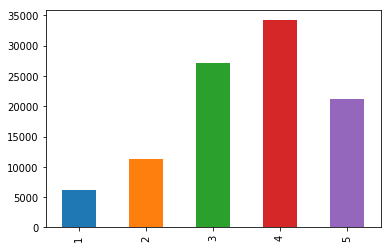

,user,item,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
5,298,474,4
6,115,265,2
7,253,465,5
8,305,451,3
9,6,86,3


In [2]:
# Matfac, for those who need a quick reminder

data = pd.read_csv('C:/Users/alexs/Downloads/datasets/ml-100k/ml-100k/u.data',
                   sep='\t', header=None, names= ['user', 'item', 'rating', 'ts']
                  ).drop('ts', axis=1)

data.rating.value_counts().sort_index().plot('bar'); plt.show()
data.head(10)

In [3]:
#What sparsity looks like

data.pivot(index='user', columns='item')

rating                                              ...                  \
item   1    2    3    4    5    6    7    8    9    10   ...  1673 1674 1675   
user                                                     ...                   
1       5.0  3.0  4.0  3.0  3.0  5.0  4.0  1.0  5.0  3.0 ...   NaN  NaN  NaN   
2       4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  2.0 ...   NaN  NaN  NaN   
3       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
4       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
5       4.0  3.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
6       4.0  NaN  NaN  NaN  NaN  NaN  2.0  4.0  4.0  NaN ...   NaN  NaN  NaN   
7       NaN  NaN  NaN  5.0  NaN  NaN  5.0  5.0  5.0  4.0 ...   NaN  NaN  NaN   
8       NaN  NaN  NaN  NaN  NaN  NaN  3.0  NaN  NaN  NaN ...   NaN  NaN  NaN   
9       NaN  NaN  NaN  NaN  NaN  5.0  4.0  NaN  NaN  NaN ...   NaN  NaN  NaN   
10      4.0  NaN  NaN  4.0  NaN  NaN  4.0  NaN  4.0  NaN ...   NaN  NaN  NaN   
11      NaN  NaN  NaN  NaN  NaN  NaN  NaN  4.0  5.0  NaN ...   NaN  NaN  NaN   
12      NaN  NaN  NaN  5.0  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
13      3.0  3.0  NaN  5.0  1.0  NaN  2.0  4.0  3.0  NaN ...   NaN  NaN  NaN   
14      NaN  NaN  NaN  NaN  NaN  NaN  5.0  NaN  4.0  NaN ...   NaN  NaN  NaN   
15      1.0  NaN  NaN  NaN  NaN  NaN  1.0  NaN  4.0  NaN ...   NaN  NaN  NaN   
16      5.0  NaN  NaN  5.0  NaN  NaN  5.0  5.0  5.0  NaN ...   NaN  NaN  NaN   
17      4.0  NaN  NaN  NaN  NaN  NaN  4.0  NaN  3.0  NaN ...   NaN  NaN  NaN   
18      5.0  NaN  NaN  3.0  NaN  5.0  NaN  5.0  5.0  NaN ...   NaN  NaN  NaN   
19      NaN  NaN  NaN  4.0  NaN  NaN  NaN  5.0  NaN  NaN ...   NaN  NaN  NaN   
20      3.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
21      5.0  NaN  NaN  NaN  2.0  NaN  5.0  NaN  5.0  NaN ...   NaN  NaN  NaN   
22      NaN  2.0  NaN  5.0  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
23      5.0  NaN  NaN  NaN  NaN  NaN  4.0  4.0  NaN  NaN ...   NaN  NaN  NaN   
24      NaN  NaN  NaN  NaN  NaN  NaN  4.0  5.0  5.0  NaN ...   NaN  NaN  NaN   
25      5.0  NaN  NaN  NaN  NaN  NaN  4.0  4.0  NaN  NaN ...   NaN  NaN  NaN   
26      3.0  NaN  NaN  NaN  NaN  NaN  3.0  NaN  4.0  NaN ...   NaN  NaN  NaN   
27      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  4.0  NaN ...   NaN  NaN  NaN   
28      NaN  NaN  NaN  NaN  3.0  NaN  5.0  NaN  NaN  NaN ...   NaN  NaN  NaN   
29      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
30      NaN  3.0  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN ...   NaN  NaN  NaN   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ... ...   ...  ...  ...   
914     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
915     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
916     4.0  3.0  3.0  4.0  3.0  NaN  4.0  NaN  5.0  NaN ...   NaN  NaN  NaN   
917     3.0  NaN  1.0  NaN  NaN  NaN  NaN  NaN  5.0  NaN ...   NaN  NaN  NaN   
918     3.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
919     4.0  NaN  NaN  1.0  4.0  NaN  3.0  NaN  5.0  NaN ...   NaN  NaN  NaN   
920     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
921     3.0  NaN  NaN  NaN  NaN  NaN  NaN  3.0  NaN  NaN ...   NaN  NaN  NaN   
922     5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
923     3.0  NaN  4.0  NaN  NaN  NaN  NaN  NaN  4.0  NaN ...   NaN  NaN  NaN   
924     5.0  3.0  NaN  NaN  NaN  4.0  4.0  NaN  4.0  NaN ...   NaN  NaN  NaN   
925     NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
926     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
927     5.0  NaN  NaN  NaN  NaN  NaN  3.0  4.0  NaN  NaN ...   NaN  NaN  NaN   
928     NaN  NaN  NaN  NaN  NaN  NaN  NaN  5.0  5.0  NaN ...   NaN  NaN  NaN   
929     3.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
930  

In [7]:
# Set up in the same way as the Fast.AI matfac exercise

unique_users = data.user.unique().tolist()
unique_items = data.item.unique().tolist()
HDIM = 20
BS = 8192 #Linear combo, so BS is kind of irrelevant

user_map = {i:n for n, i in enumerate(unique_users)}
item_map = {i:n for n, i in enumerate(unique_items)}

X_train, X_test = tts(
  pd.concat([data.user.map(user_map),data.item.map(item_map), data.rating**3], axis=1).values,
  test_size = 0.2)

test_dl = DataLoader(TensorDataset(torch.from_numpy(X_test)), batch_size=BS,
                     shuffle=False, num_workers = 7)
train_dl = DataLoader(TensorDataset(torch.from_numpy(X_train)), batch_size=BS,
                      shuffle=True, num_workers = 7)

class PFac(nn.Module):
  def __init__(self, hidden_dim= HDIM,
               n_u = len(unique_users),
               n_i = len(unique_items)
              ):
    super(PFac, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_u = n_u; self.n_i = n_i
    self.sp = nn.Softplus()
    
  def model(self, x, rate=True):
    bs = x.size()[0]
    users, items, ratings = x[:,0], x[:,1], x[:,2].view(-1,1).float()
    shape_prior = torch.ones(bs, self.hidden_dim) * 1 # prior for 'a' and 'c'
    mean_prior = torch.ones(1) * 0.5 # prior for 'b' and 'd'
    with pyro.iarange('data', bs):
      user_latent = pyro.sample('theta', dist.Gamma(shape_prior, mean_prior).independent(1))
      item_latent = pyro.sample('beta', dist.Gamma(shape_prior, mean_prior).independent(1))
      y_rate = (user_latent * item_latent).sum(1)
      pyro.sample('y', dist.Poisson(y_rate.view(-1,1)).independent(1), obs= ratings)
    
  def guide(self, x, rate=True):
    users, items = x[:,0], x[:,1]
    log_a = pyro.param('log_a', torch.zeros(self.n_u, self.hidden_dim)-\
                       torch.randn(self.n_u, self.hidden_dim))
    log_b = pyro.param('log_b', torch.zeros(1)-torch.randn(1)).view(-1,1)
    log_c = pyro.param('log_c', torch.zeros(self.n_i, self.hidden_dim)-\
                       torch.randn(self.n_i, self.hidden_dim))
    log_d = pyro.param('log_d', torch.zeros(1)-torch.randn(1)).view(-1,1)
    with pyro.iarange('data', x.size()[0]):
      theta_batch = dist.Gamma(self.sp(log_a.index_select(0, users)), self.sp(log_b)).independent(1)
      beta_batch = dist.Gamma(self.sp(log_c.index_select(0, items)), self.sp(log_d)).independent(1)
      user_latent = pyro.sample('theta', theta_batch)
      item_latent = pyro.sample('beta', beta_batch)
      y_rate = (user_latent * item_latent).sum(1)
      y = pyro.sample('y', dist.Poisson(y_rate.view(-1,1)).independent(1)).view(-1)
      if rate: return y_rate
      else: return y

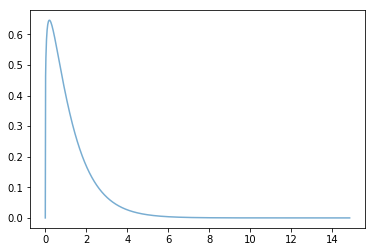

In [47]:
# Show off Gamma distribution
a = 1.2 # <<< THIS IS THE ONE WE REALLY CARE ABOUT
b = 0.5
x = np.linspace(gamma.ppf(0.0, a, scale=1/b), gamma.ppf(0.999, a, scale=1/b), 1000)
plt.plot(x, gamma.pdf(x, a), alpha=0.6, label='gamma pdf')

[epoch 000]  average training loss: 81.7464


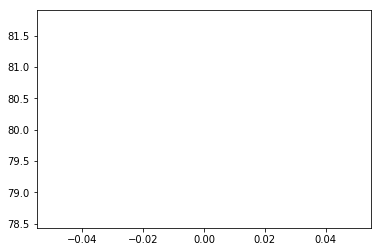

[epoch 001]  average training loss: 75.9947
[epoch 002]  average training loss: 70.4116
[epoch 003]  average training loss: 65.8641
[epoch 004]  average training loss: 61.9222
[epoch 005]  average training loss: 58.2044
[epoch 006]  average training loss: 54.9228
[epoch 007]  average training loss: 51.9050
[epoch 008]  average training loss: 49.3253
[epoch 009]  average training loss: 46.8537
[epoch 010]  average training loss: 44.6078
[epoch 011]  average training loss: 42.6563
[epoch 012]  average training loss: 40.7967
[epoch 013]  average training loss: 39.2999
[epoch 014]  average training loss: 37.8970
[epoch 015]  average training loss: 36.5975
[epoch 016]  average training loss: 35.5915
[epoch 017]  average training loss: 34.3990
[epoch 018]  average training loss: 33.5149
[epoch 019]  average training loss: 32.7815
[epoch 020]  average training loss: 31.8955


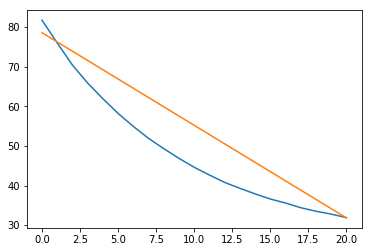

[epoch 021]  average training loss: 31.0258
[epoch 022]  average training loss: 30.5960
[epoch 023]  average training loss: 29.6847
[epoch 024]  average training loss: 29.4790
[epoch 025]  average training loss: 28.7289
[epoch 026]  average training loss: 28.3758
[epoch 027]  average training loss: 27.8707
[epoch 028]  average training loss: 27.4690
[epoch 029]  average training loss: 27.1188
[epoch 030]  average training loss: 26.6390
[epoch 031]  average training loss: 26.3329
[epoch 032]  average training loss: 26.1469
[epoch 033]  average training loss: 25.5978
[epoch 034]  average training loss: 25.4561
[epoch 035]  average training loss: 25.1125
[epoch 036]  average training loss: 24.8588
[epoch 037]  average training loss: 24.4461
[epoch 038]  average training loss: 24.3931
[epoch 039]  average training loss: 24.0521
[epoch 040]  average training loss: 23.8335


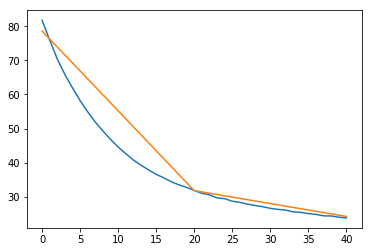

[epoch 041]  average training loss: 23.6308
[epoch 042]  average training loss: 23.4117
[epoch 043]  average training loss: 23.2910
[epoch 044]  average training loss: 22.9304
[epoch 045]  average training loss: 22.8660
[epoch 046]  average training loss: 22.6442
[epoch 047]  average training loss: 22.6060
[epoch 048]  average training loss: 22.2498
[epoch 049]  average training loss: 22.1129
[epoch 050]  average training loss: 21.9842
[epoch 051]  average training loss: 21.8849
[epoch 052]  average training loss: 21.7984
[epoch 053]  average training loss: 21.6195
[epoch 054]  average training loss: 21.4016
[epoch 055]  average training loss: 21.3868
[epoch 056]  average training loss: 21.2116
[epoch 057]  average training loss: 20.9509
[epoch 058]  average training loss: 20.9377
[epoch 059]  average training loss: 20.9155
[epoch 060]  average training loss: 20.8085


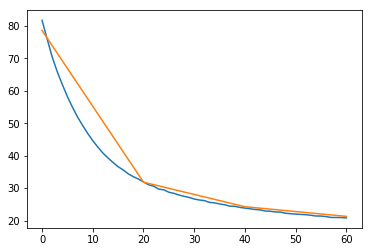

[epoch 061]  average training loss: 20.6355
[epoch 062]  average training loss: 20.5248
[epoch 063]  average training loss: 20.4675
[epoch 064]  average training loss: 20.3438
[epoch 065]  average training loss: 20.1446
[epoch 066]  average training loss: 20.1726
[epoch 067]  average training loss: 20.1340
[epoch 068]  average training loss: 19.9653
[epoch 069]  average training loss: 19.9238
[epoch 070]  average training loss: 19.8150
[epoch 071]  average training loss: 19.7124
[epoch 072]  average training loss: 19.7180
[epoch 073]  average training loss: 19.5771
[epoch 074]  average training loss: 19.3976
[epoch 075]  average training loss: 19.4345
[epoch 076]  average training loss: 19.3398
[epoch 077]  average training loss: 19.2812
[epoch 078]  average training loss: 19.3101
[epoch 079]  average training loss: 19.1725
[epoch 080]  average training loss: 19.0356


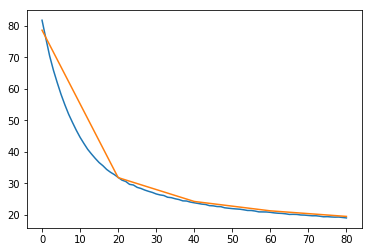

[epoch 081]  average training loss: 19.1103
[epoch 082]  average training loss: 18.9776
[epoch 083]  average training loss: 18.9602
[epoch 084]  average training loss: 18.9488
[epoch 085]  average training loss: 18.8478
[epoch 086]  average training loss: 18.7767
[epoch 087]  average training loss: 18.7693
[epoch 088]  average training loss: 18.7055
[epoch 089]  average training loss: 18.7087
[epoch 090]  average training loss: 18.5516
[epoch 091]  average training loss: 18.5489
[epoch 092]  average training loss: 18.4745
[epoch 093]  average training loss: 18.4215
[epoch 094]  average training loss: 18.3420
[epoch 095]  average training loss: 18.3656
[epoch 096]  average training loss: 18.4380
[epoch 097]  average training loss: 18.1995
[epoch 098]  average training loss: 18.2224
[epoch 099]  average training loss: 18.1869
Final val loss: 18.9407


In [8]:
optimizer = Adam({'lr':1e-2})        
pfac = PFac()
svi = SVI(pfac.model, pfac.guide, optimizer, loss=Trace_ELBO())

FREQ = 20
train_elbo = []
test_elbo = []
for epoch in range(100):
  total_epoch_loss_train = train(svi, train_dl)
  train_elbo.append(total_epoch_loss_train)
  print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
  if (epoch%FREQ) == 0:
    total_epoch_loss_test = val(svi, test_dl)
    test_elbo.append(total_epoch_loss_test)
    plot_loss(train_elbo, test_elbo, FREQ)
print('Final val loss: %.4f' % val(svi, test_dl))

In [ ]:
first = True
rate = True
samples = 16

for n in range(samples):
  if first:
    out = test(svi, test_dl, rate)
  else:
    out += test(svi, test_dl, rate)
plt.figure()
out.div(samples).groupby(X_test[:,2]).plot.kde()
plt.xlim(0, out.div(samples).max())
plt.plot()

In [ ]:
out = pyro.get_param_store()
# plt.plot(pfac.sp(pyro.param('log_a')).detach().numpy(), alpha=0.25)#.mean(axis=0))
pfac.sp(pyro.param('log_d')).detach().numpy().mean()

In [ ]:
pd.Series(
  np.random.gamma(
    pfac.sp(pyro.param('log_c')).detach().numpy()[1,:],
    pfac.sp(pyro.param('log_d')).detach().numpy())
).plot('bar')

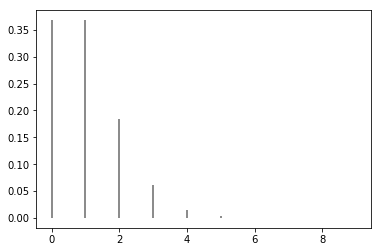

In [58]:
# Poisson Distribution
lmda = 1
x = np.arange(0, 10)
plt.vlines(x, 0, poisson.pmf(x, lmda), alpha=0.6, label='gamma pdf')